# 23. 不均衡データ対策 - クラス不均衡問題の解決 (Imbalanced Data Handling)

## 概要
クラス不均衡問題に対処するための実践的な手法を学びます。SMOTE、Focal Loss、コスト考慮学習など、実務で頻出するテクニックを網羅します。

## 学習目標
- 不均衡データの問題点を理解できる
- 適切な評価指標を選択できる
- リサンプリング手法を使いこなせる
- アルゴリズムレベルの対策ができる
- 実務でのベストプラクティスを適用できる

In [14]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, roc_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


## 1. なぜ不均衡データは問題なのか

### クラス不均衡とは

**クラス不均衡（Class Imbalance）**は、分類問題において各クラスのサンプル数が大きく偏っている状態です。

### 実世界での例

1. **クレジットカード不正検知**
   - 正常取引: 99.9%
   - 不正取引: 0.1%

2. **医療診断**
   - 健康: 95%
   - 疾患: 5%

3. **機械故障予測**
   - 正常稼働: 98%
   - 故障: 2%

### 何が問題か

多数派クラスに偏った予測をしても、高い精度を達成できてしまう：

```python
# 例: 不正検知で「全て正常」と予測
# → 精度99.9%達成！でも不正は1件も検知できない
```

## 2. 不均衡データの準備と問題の可視化

In [15]:
# 不均衡データの生成（不正検知を模擬）
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=2,
    weights=[0.95, 0.05],  # 95% vs 5%の不均衡
    flip_y=0.01,
    random_state=42
)

# データ分割（層化抽出を使用）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"データサイズ: {X.shape}")
print(f"\nクラス分布:")
print(f"訓練データ: {Counter(y_train)}")
print(f"テストデータ: {Counter(y_test)}")
print(f"\n不均衡率: {Counter(y_train)[0] / Counter(y_train)[1]:.1f}:1")

データサイズ: (10000, 20)

クラス分布:
訓練データ: Counter({np.int64(0): 6623, np.int64(1): 377})
テストデータ: Counter({np.int64(0): 2838, np.int64(1): 162})

不均衡率: 17.6:1


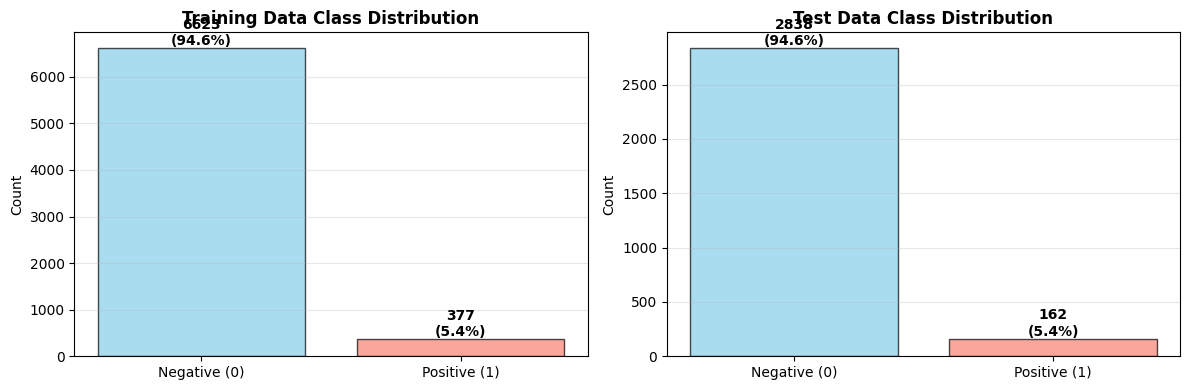


⚠️ 問題点:
- 少数派クラス（Positive）が全体の約5%しかない
- このままでは多数派に偏った予測をするモデルになりやすい


In [16]:
# クラス分布の可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 訓練データ
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(['Negative (0)', 'Positive (1)'], train_counts.values, 
            color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0].set_title('Training Data Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v, f'{v}\n({v/len(y_train)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# テストデータ
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1].bar(['Negative (0)', 'Positive (1)'], test_counts.values,
            color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[1].set_title('Test Data Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v, f'{v}\n({v/len(y_test)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ 問題点:")
print("- 少数派クラス（Positive）が全体の約5%しかない")
print("- このままでは多数派に偏った予測をするモデルになりやすい")

## 3. ベースラインモデル: 問題の確認

まず、何も対策せずにモデルを学習させて問題を確認します。

In [17]:
# ベースラインモデル（対策なし）
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# 予測
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# 評価
print("=" * 60)
print("ベースラインモデルの性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_baseline):.4f}")
print("\n混同行列:")
print(confusion_matrix(y_test, y_pred_baseline))
print("\n⚠️ 注意:")
print("- Accuracyは高いが、Recall（再現率）が低い")
print("- 少数派クラスを見逃している可能性がある")

ベースラインモデルの性能
Accuracy:  0.9630
Precision: 0.9636
Recall:    0.3272
F1-Score:  0.4885
ROC-AUC:   0.8420

混同行列:
[[2836    2]
 [ 109   53]]

⚠️ 注意:
- Accuracyは高いが、Recall（再現率）が低い
- 少数派クラスを見逃している可能性がある


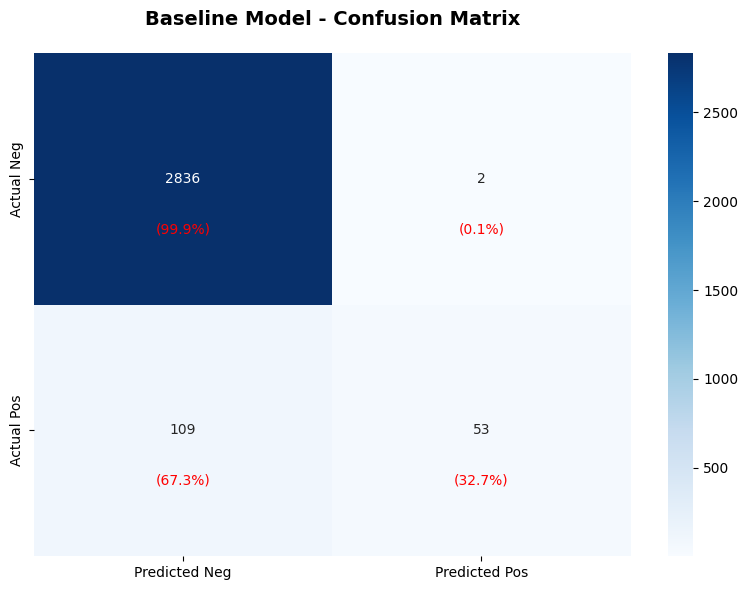


詳細指標:
- True Negatives (TN):  2836 (正しくネガティブと予測)
- False Positives (FP): 2 (誤ってポジティブと予測)
- False Negatives (FN): 109 (誤ってネガティブと予測) ⚠️
- True Positives (TP):  53 (正しくポジティブと予測)

⚠️ FN（見逃し）が多いと問題！


In [18]:
# 詳細な可視化
def plot_confusion_matrix_detailed(y_true, y_pred, title):
    """詳細な混同行列を可視化"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Predicted Neg', 'Predicted Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'],
                ax=ax)
    
    # パーセンテージを追加
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / cm[i].sum() * 100
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                   ha='center', va='center', fontsize=10, color='red')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 指標の説明
    tn, fp, fn, tp = cm.ravel()
    print(f"\n詳細指標:")
    print(f"- True Negatives (TN):  {tn} (正しくネガティブと予測)")
    print(f"- False Positives (FP): {fp} (誤ってポジティブと予測)")
    print(f"- False Negatives (FN): {fn} (誤ってネガティブと予測) ⚠️")
    print(f"- True Positives (TP):  {tp} (正しくポジティブと予測)")
    print(f"\n⚠️ FN（見逃し）が多いと問題！")

plot_confusion_matrix_detailed(y_test, y_pred_baseline, 
                                'Baseline Model - Confusion Matrix')

## 4. 評価指標の選択

### Accuracyの罠

不均衡データでは**Accuracy（正解率）は適切な指標ではありません**。

### 適切な評価指標

1. **Precision（精度）**: 陽性と予測したもののうち、実際に陽性だった割合
   - 重要な場面: 誤検知のコストが高い（スパムメール検知など）

2. **Recall（再現率）**: 実際の陽性のうち、正しく予測できた割合
   - 重要な場面: 見逃しのコストが高い（疾患診断など）

3. **F1-Score**: PrecisionとRecallの調和平均
   - バランスを取りたい場合

4. **ROC-AUC**: 閾値に依存しない総合的な性能
   - モデルの識別能力を評価

5. **PR-AUC**: Precision-Recall曲線下面積
   - 不均衡データに対してROC-AUCより適切

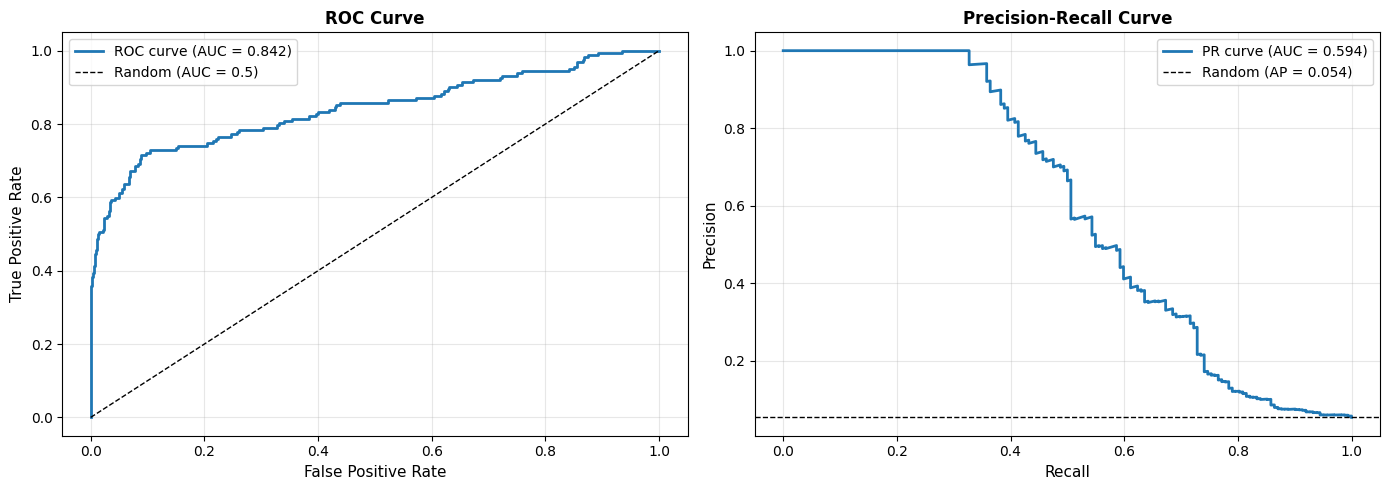


💡 ポイント:
- ROC曲線: 全体的な識別能力を評価
- PR曲線: 不均衡データでより有用（少数派クラスに焦点）
- PR-AUC (0.594) がベースライン (0.054) より高いことが重要


In [19]:
# ROC曲線とPR曲線の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC曲線
fpr, tpr, _ = roc_curve(y_test, y_proba_baseline)
roc_auc = roc_auc_score(y_test, y_proba_baseline)
axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# PR曲線
precision, recall, _ = precision_recall_curve(y_test, y_proba_baseline)
pr_auc = average_precision_score(y_test, y_proba_baseline)
axes[1].plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})', linewidth=2)
baseline_precision = sum(y_test) / len(y_test)
axes[1].axhline(baseline_precision, color='k', linestyle='--', 
                label=f'Random (AP = {baseline_precision:.3f})', linewidth=1)
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 ポイント:")
print("- ROC曲線: 全体的な識別能力を評価")
print("- PR曲線: 不均衡データでより有用（少数派クラスに焦点）")
print(f"- PR-AUC ({pr_auc:.3f}) がベースライン ({baseline_precision:.3f}) より高いことが重要")

## 5. 対策1: リサンプリング手法

### リサンプリングの種類

1. **オーバーサンプリング**: 少数派クラスを増やす
   - Random Over-sampling
   - SMOTE (Synthetic Minority Over-sampling Technique)
   - ADASYN, BorderlineSMOTE

2. **アンダーサンプリング**: 多数派クラスを減らす
   - Random Under-sampling
   - Tomek Links
   - Edited Nearest Neighbours

3. **ハイブリッド**: 両方を組み合わせる
   - SMOTEENN
   - SMOTETomek

### 5.1 SMOTE (Synthetic Minority Over-sampling Technique)

In [20]:
# SMOTEによるオーバーサンプリング
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTEによるリサンプリング結果:")
print(f"元の訓練データ: {Counter(y_train)}")
print(f"SMOTE後: {Counter(y_train_smote)}")
print(f"\nサンプル数の変化: {len(y_train)} → {len(y_train_smote)}")

# SMOTEの仕組みの可視化
print("\n💡 SMOTEの仕組み:")
print("1. 少数派クラスの各サンプルについて、k近傍を見つける")
print("2. その近傍の1つをランダムに選ぶ")
print("3. 2つのサンプル間に新しい合成サンプルを生成")
print("   new_sample = sample + λ * (neighbor - sample), λ ∈ [0, 1]")

SMOTEによるリサンプリング結果:
元の訓練データ: Counter({np.int64(0): 6623, np.int64(1): 377})
SMOTE後: Counter({np.int64(0): 6623, np.int64(1): 6623})

サンプル数の変化: 7000 → 13246

💡 SMOTEの仕組み:
1. 少数派クラスの各サンプルについて、k近傍を見つける
2. その近傍の1つをランダムに選ぶ
3. 2つのサンプル間に新しい合成サンプルを生成
   new_sample = sample + λ * (neighbor - sample), λ ∈ [0, 1]


SMOTEを使ったモデルの性能
Accuracy:  0.8417
Precision: 0.2149
Recall:    0.7284 ⬆️
F1-Score:  0.3319
ROC-AUC:   0.8530

改善点:
- Recall: 0.3272 → 0.7284
- F1-Score: 0.4885 → 0.3319


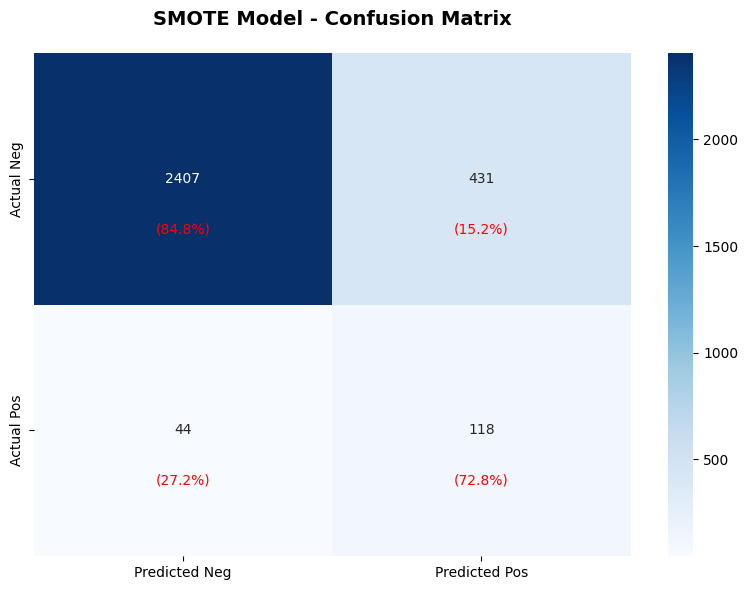


詳細指標:
- True Negatives (TN):  2407 (正しくネガティブと予測)
- False Positives (FP): 431 (誤ってポジティブと予測)
- False Negatives (FN): 44 (誤ってネガティブと予測) ⚠️
- True Positives (TP):  118 (正しくポジティブと予測)

⚠️ FN（見逃し）が多いと問題！


In [21]:
# SMOTEを使ったモデル学習
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)

# 予測（テストデータはリサンプリングしない！）
y_pred_smote = model_smote.predict(X_test)
y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# 評価
print("=" * 60)
print("SMOTEを使ったモデルの性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_smote):.4f} ⬆️")
print(f"F1-Score:  {f1_score(y_test, y_pred_smote):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_smote):.4f}")

print("\n改善点:")
print(f"- Recall: {recall_score(y_test, y_pred_baseline):.4f} → {recall_score(y_test, y_pred_smote):.4f}")
print(f"- F1-Score: {f1_score(y_test, y_pred_baseline):.4f} → {f1_score(y_test, y_pred_smote):.4f}")

plot_confusion_matrix_detailed(y_test, y_pred_smote, 'SMOTE Model - Confusion Matrix')

### 5.2 その他のリサンプリング手法の比較

In [22]:
# 複数のリサンプリング手法を比較
resamplers = {
    'Baseline (No Resampling)': None,
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

results = []

for name, resampler in resamplers.items():
    # リサンプリング
    if resampler is None:
        X_train_res, y_train_res = X_train, y_train
    else:
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
    
    # モデル学習
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_res, y_train_res)
    
    # 予測
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 評価
    results.append({
        'Method': name,
        'Samples': len(y_train_res),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba)
    })

# 結果をDataFrameに
results_df = pd.DataFrame(results)
print("\n" + "=" * 100)
print("リサンプリング手法の比較")
print("=" * 100)
print(results_df.to_string(index=False))

# ベストパフォーマンス
print("\n🏆 各指標でのベスト:")
for col in ['Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']:
    best_idx = results_df[col].idxmax()
    print(f"- {col}: {results_df.loc[best_idx, 'Method']} ({results_df.loc[best_idx, col]:.4f})")


リサンプリング手法の比較
                  Method  Samples  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
Baseline (No Resampling)     7000  0.963000   0.963636 0.327160  0.488479 0.841971 0.594004
                   SMOTE    13246  0.841667   0.214936 0.728395  0.331927 0.853024 0.569391
                  ADASYN    13243  0.796667   0.180000 0.777778  0.292343 0.859114 0.544174
         BorderlineSMOTE    13246  0.853667   0.228963 0.722222  0.347697 0.851014 0.564014
      RandomUnderSampler      754  0.813667   0.189358 0.746914  0.302122 0.852515 0.554261
                SMOTEENN    12758  0.827000   0.201005 0.740741  0.316206 0.854310 0.566897
              SMOTETomek    13246  0.841667   0.214936 0.728395  0.331927 0.853024 0.569391

🏆 各指標でのベスト:
- Recall: ADASYN (0.7778)
- F1-Score: Baseline (No Resampling) (0.4885)
- ROC-AUC: ADASYN (0.8591)
- PR-AUC: Baseline (No Resampling) (0.5940)


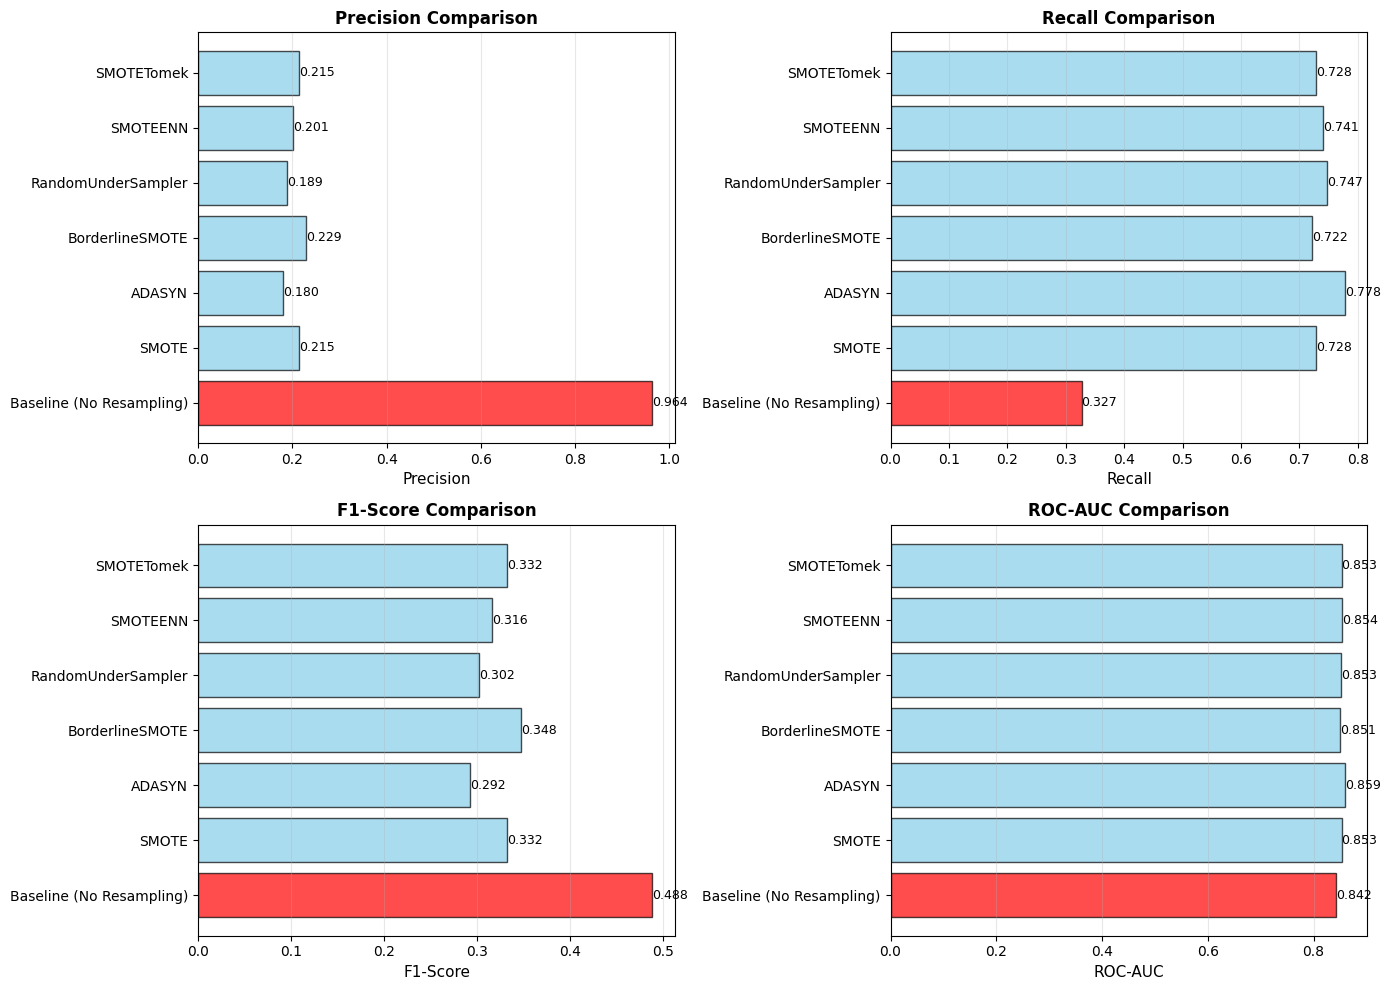


💡 観察:
- リサンプリングによりRecallが改善
- ただし、Precisionはやや低下する傾向
- バランスを取るならSMOTE系が有効


In [23]:
# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # ベースラインを強調
    colors = ['red' if m == 'Baseline (No Resampling)' else 'skyblue' 
              for m in results_df['Method']]
    
    bars = ax.barh(results_df['Method'], results_df[metric], color=colors, 
                   alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 値のラベル
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("- リサンプリングによりRecallが改善")
print("- ただし、Precisionはやや低下する傾向")
print("- バランスを取るならSMOTE系が有効")

## 6. 対策2: アルゴリズムレベルの手法

### 6.1 クラス重み付け（Class Weights）

データを増減させる代わりに、学習時に少数派クラスの重要度を上げる方法です。

In [24]:
# クラス重みの自動計算
from sklearn.utils.class_weight import compute_class_weight

# 手動計算
class_weights_manual = {
    0: len(y_train) / (2 * Counter(y_train)[0]),
    1: len(y_train) / (2 * Counter(y_train)[1])
}

print("クラス重み:")
print(f"- クラス0（多数派）: {class_weights_manual[0]:.3f}")
print(f"- クラス1（少数派）: {class_weights_manual[1]:.3f}")
print(f"\n少数派クラスの重みは多数派の {class_weights_manual[1] / class_weights_manual[0]:.1f}倍")

クラス重み:
- クラス0（多数派）: 0.528
- クラス1（少数派）: 9.284

少数派クラスの重みは多数派の 17.6倍


In [25]:
# クラス重み付きモデル
model_weighted = LogisticRegression(
    class_weight='balanced',  # 自動で重みを調整
    random_state=42,
    max_iter=1000
)
model_weighted.fit(X_train, y_train)

# 予測
y_pred_weighted = model_weighted.predict(X_test)
y_proba_weighted = model_weighted.predict_proba(X_test)[:, 1]

# 評価
print("=" * 60)
print("クラス重み付きモデルの性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_weighted):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_weighted):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_weighted):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_weighted):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_weighted):.4f}")

print("\n💡 メリット:")
print("- データを増やさないので、過学習のリスクが低い")
print("- 計算コストが低い（データサイズが変わらない）")
print("- scikit-learnの多くのモデルで利用可能")

クラス重み付きモデルの性能
Accuracy:  0.8347
Precision: 0.2101
Recall:    0.7469
F1-Score:  0.3279
ROC-AUC:   0.8555

💡 メリット:
- データを増やさないので、過学習のリスクが低い
- 計算コストが低い（データサイズが変わらない）
- scikit-learnの多くのモデルで利用可能


### 6.2 閾値調整（Threshold Tuning）

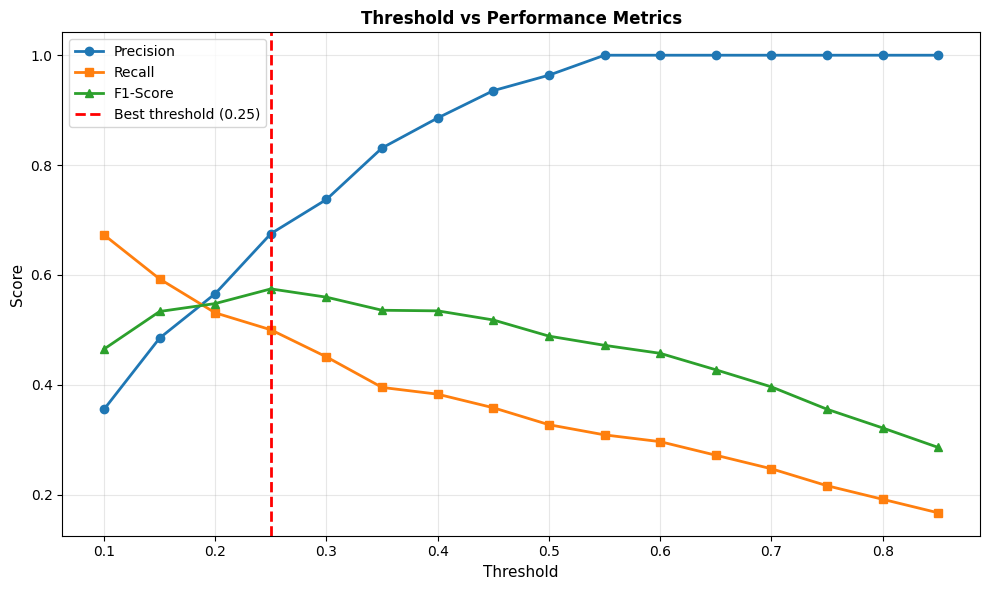


最適閾値: 0.25
F1-Score: 0.5745

デフォルト閾値(0.5)との比較:
- デフォルト F1: 0.4885
- 最適 F1: 0.5745
- 改善: 0.0860


In [26]:
# 閾値を変えた場合の性能変化を調べる
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_proba_baseline >= threshold).astype(int)
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_threshold, zero_division=0),
        'Recall': recall_score(y_test, y_pred_threshold),
        'F1-Score': f1_score(y_test, y_pred_threshold)
    })

threshold_df = pd.DataFrame(threshold_results)

# 可視化
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 
         label='Precision', marker='o', linewidth=2)
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], 
         label='Recall', marker='s', linewidth=2)
plt.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 
         label='F1-Score', marker='^', linewidth=2)

# 最適閾値（F1-Scoreが最大）
best_threshold_idx = threshold_df['F1-Score'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
plt.axvline(best_threshold, color='red', linestyle='--', 
            label=f'Best threshold ({best_threshold:.2f})', linewidth=2)

plt.xlabel('Threshold', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Threshold vs Performance Metrics', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n最適閾値: {best_threshold:.2f}")
print(f"F1-Score: {threshold_df.loc[best_threshold_idx, 'F1-Score']:.4f}")

# デフォルト閾値(0.5)との比較（最も近い値を使用）
print(f"\nデフォルト閾値(0.5)との比較:")
default_idx = (threshold_df['Threshold'] - 0.5).abs().idxmin()
if len(threshold_df) > default_idx:
    print(f"- デフォルト F1: {threshold_df.loc[default_idx, 'F1-Score']:.4f}")
    print(f"- 最適 F1: {threshold_df.loc[best_threshold_idx, 'F1-Score']:.4f}")
    print(f"- 改善: {threshold_df.loc[best_threshold_idx, 'F1-Score'] - threshold_df.loc[default_idx, 'F1-Score']:.4f}")

### 6.3 コスト考慮学習（Cost-Sensitive Learning）

In [27]:
# カスタムコスト関数
def cost_sensitive_score(y_true, y_pred, fp_cost=1, fn_cost=10):
    """
    コスト考慮型のスコア計算
    
    Parameters:
    -----------
    fp_cost : float
        False Positive（誤検知）のコスト
    fn_cost : float
        False Negative（見逃し）のコスト
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return -total_cost  # 負のコスト（最小化 → 最大化に変換）

# 異なるコスト比率での最適閾値を探索
cost_ratios = [1, 5, 10, 20]

print("異なるコスト比率での最適閾値:")
print("=" * 60)

for fn_cost in cost_ratios:
    best_score = float('-inf')
    best_threshold_cost = 0.5
    
    for threshold in thresholds:
        y_pred_threshold = (y_proba_baseline >= threshold).astype(int)
        score = cost_sensitive_score(y_test, y_pred_threshold, fp_cost=1, fn_cost=fn_cost)
        
        if score > best_score:
            best_score = score
            best_threshold_cost = threshold
    
    print(f"FN/FP コスト比 = {fn_cost}:1 → 最適閾値 = {best_threshold_cost:.2f}")

print("\n💡 観察:")
print("- 見逃しのコストが高いほど、閾値を下げる（Recallを優先）")
print("- ビジネス要件に応じて適切な閾値を選択")

異なるコスト比率での最適閾値:
FN/FP コスト比 = 1:1 → 最適閾値 = 0.40
FN/FP コスト比 = 5:1 → 最適閾値 = 0.15
FN/FP コスト比 = 10:1 → 最適閾値 = 0.10
FN/FP コスト比 = 20:1 → 最適閾値 = 0.10

💡 観察:
- 見逃しのコストが高いほど、閾値を下げる（Recallを優先）
- ビジネス要件に応じて適切な閾値を選択


## 7. 対策3: アンサンブル学習

### 7.1 EasyEnsemble

多数派をランダムにサブサンプリングして複数のバランスの取れたデータセットを作成し、各データセットで学習したモデルをアンサンブルします。

In [28]:
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

# EasyEnsemble
easy_ensemble = EasyEnsembleClassifier(n_estimators=10, random_state=42)
easy_ensemble.fit(X_train, y_train)

y_pred_ee = easy_ensemble.predict(X_test)
y_proba_ee = easy_ensemble.predict_proba(X_test)[:, 1]

print("=" * 60)
print("EasyEnsemble の性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_ee):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ee):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_ee):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_ee):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_ee):.4f}")

EasyEnsemble の性能
Accuracy:  0.8147
Precision: 0.1922
Recall:    0.7593
F1-Score:  0.3067
ROC-AUC:   0.8474


### 7.2 Balanced Random Forest

In [29]:
# Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
balanced_rf.fit(X_train, y_train)

y_pred_brf = balanced_rf.predict(X_test)
y_proba_brf = balanced_rf.predict_proba(X_test)[:, 1]

print("=" * 60)
print("Balanced Random Forest の性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_brf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_brf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_brf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_brf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_brf):.4f}")

Balanced Random Forest の性能
Accuracy:  0.9197
Precision: 0.3842
Recall:    0.8086
F1-Score:  0.5209
ROC-AUC:   0.9381


## 8. GBDT + 不均衡データ対策

LightGBM、XGBoost、CatBoostは不均衡データに対する組み込みサポートがあります。

In [30]:
import lightgbm as lgb
import xgboost as xgb

# LightGBM with scale_pos_weight
scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("=" * 60)
print("LightGBM (scale_pos_weight) の性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_lgb):.4f}")

# XGBoost with scale_pos_weight
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n" + "=" * 60)
print("XGBoost (scale_pos_weight) の性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_xgb):.4f}")

LightGBM (scale_pos_weight) の性能
Accuracy:  0.9783
Precision: 0.9145
Recall:    0.6605
F1-Score:  0.7670
ROC-AUC:   0.9500

XGBoost (scale_pos_weight) の性能
Accuracy:  0.9780
Precision: 0.9706
Recall:    0.6111
F1-Score:  0.7500
ROC-AUC:   0.9472


## 9. Focal Loss の実装

**Focal Loss**は、RetinaNetで提案された損失関数で、簡単なサンプルの重みを下げ、難しいサンプルに集中する手法です。

$$
FL(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)
$$

- $\gamma$: focusing parameter（難しいサンプルへの注目度）
- $\alpha_t$: クラス重み

In [31]:
# LightGBM用のカスタムFocal Loss
def focal_loss_lgb(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    LightGBM用のFocal Loss実装
    
    Parameters:
    -----------
    alpha : float
        クラス重み（0.25が推奨値）
    gamma : float
        focusing parameter（2.0が推奨値）
    """
    a, g = alpha, gamma
    
    def fl(y_true, y_pred):
        # シグモイド関数で確率に変換
        p = 1.0 / (1.0 + np.exp(-y_pred))
        
        # Focal Loss の勾配
        grad = a * (g * (y_true - p) * np.power(1 - p, g - 1) * p * (1 - p) + 
                   np.power(1 - p, g) * (y_true - p))
        
        # ヘッセ行列（2次微分）
        hess = a * g * (g - 1) * np.power(1 - p, g - 2) * p * (1 - p) * (y_true - p) + \
               a * g * np.power(1 - p, g - 1) * ((1 - p) - p) * (y_true - p) + \
               a * np.power(1 - p, g) * (1)
        hess = np.abs(hess)  # 絶対値を取る（安定性のため）
        
        return grad, hess
    
    return fl(y_true, y_pred)

# Focal Lossを使ったLightGBM
lgb_focal = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    verbose=-1
)

# カスタム目的関数として使用
lgb_focal.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
)

y_pred_focal = lgb_focal.predict(X_test)
y_proba_focal = lgb_focal.predict_proba(X_test)[:, 1]

print("=" * 60)
print("LightGBM with Focal Loss の性能")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_focal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_focal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_focal):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_focal):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_focal):.4f}")

print("\n💡 Focal Lossの特徴:")
print("- 難しいサンプル（誤分類されやすい）に集中")
print("- 簡単なサンプル（正しく分類できる）の影響を減らす")
print("- 極端な不均衡データで特に有効")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0928732
LightGBM with Focal Loss の性能
Accuracy:  0.9717
Precision: 1.0000
Recall:    0.4753
F1-Score:  0.6444
ROC-AUC:   0.9392

💡 Focal Lossの特徴:
- 難しいサンプル（誤分類されやすい）に集中
- 簡単なサンプル（正しく分類できる）の影響を減らす
- 極端な不均衡データで特に有効


## 10. 全手法の総合比較

In [32]:
# 全モデルの結果を集約
all_results = pd.DataFrame([
    {
        'Method': 'Baseline',
        'Precision': precision_score(y_test, y_pred_baseline),
        'Recall': recall_score(y_test, y_pred_baseline),
        'F1-Score': f1_score(y_test, y_pred_baseline),
        'ROC-AUC': roc_auc_score(y_test, y_proba_baseline)
    },
    {
        'Method': 'SMOTE',
        'Precision': precision_score(y_test, y_pred_smote),
        'Recall': recall_score(y_test, y_pred_smote),
        'F1-Score': f1_score(y_test, y_pred_smote),
        'ROC-AUC': roc_auc_score(y_test, y_proba_smote)
    },
    {
        'Method': 'Class Weights',
        'Precision': precision_score(y_test, y_pred_weighted),
        'Recall': recall_score(y_test, y_pred_weighted),
        'F1-Score': f1_score(y_test, y_pred_weighted),
        'ROC-AUC': roc_auc_score(y_test, y_proba_weighted)
    },
    {
        'Method': 'EasyEnsemble',
        'Precision': precision_score(y_test, y_pred_ee),
        'Recall': recall_score(y_test, y_pred_ee),
        'F1-Score': f1_score(y_test, y_pred_ee),
        'ROC-AUC': roc_auc_score(y_test, y_proba_ee)
    },
    {
        'Method': 'Balanced RF',
        'Precision': precision_score(y_test, y_pred_brf),
        'Recall': recall_score(y_test, y_pred_brf),
        'F1-Score': f1_score(y_test, y_pred_brf),
        'ROC-AUC': roc_auc_score(y_test, y_proba_brf)
    },
    {
        'Method': 'LightGBM',
        'Precision': precision_score(y_test, y_pred_lgb),
        'Recall': recall_score(y_test, y_pred_lgb),
        'F1-Score': f1_score(y_test, y_pred_lgb),
        'ROC-AUC': roc_auc_score(y_test, y_proba_lgb)
    },
    {
        'Method': 'XGBoost',
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-Score': f1_score(y_test, y_pred_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_proba_xgb)
    },
    {
        'Method': 'LightGBM + Focal',
        'Precision': precision_score(y_test, y_pred_focal),
        'Recall': recall_score(y_test, y_pred_focal),
        'F1-Score': f1_score(y_test, y_pred_focal),
        'ROC-AUC': roc_auc_score(y_test, y_proba_focal)
    }
])

print("\n" + "=" * 80)
print("全手法の性能比較")
print("=" * 80)
print(all_results.to_string(index=False))

# 各指標でのベスト
print("\n🏆 各指標でのベストモデル:")
for col in ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = all_results[col].idxmax()
    print(f"- {col}: {all_results.loc[best_idx, 'Method']} ({all_results.loc[best_idx, col]:.4f})")


全手法の性能比較
          Method  Precision   Recall  F1-Score  ROC-AUC
        Baseline   0.963636 0.327160  0.488479 0.841971
           SMOTE   0.214936 0.728395  0.331927 0.853024
   Class Weights   0.210069 0.746914  0.327913 0.855515
    EasyEnsemble   0.192188 0.759259  0.306733 0.847432
     Balanced RF   0.384164 0.808642  0.520875 0.938060
        LightGBM   0.914530 0.660494  0.767025 0.949978
         XGBoost   0.970588 0.611111  0.750000 0.947150
LightGBM + Focal   1.000000 0.475309  0.644351 0.939233

🏆 各指標でのベストモデル:
- Precision: LightGBM + Focal (1.0000)
- Recall: Balanced RF (0.8086)
- F1-Score: LightGBM (0.7670)
- ROC-AUC: LightGBM (0.9500)


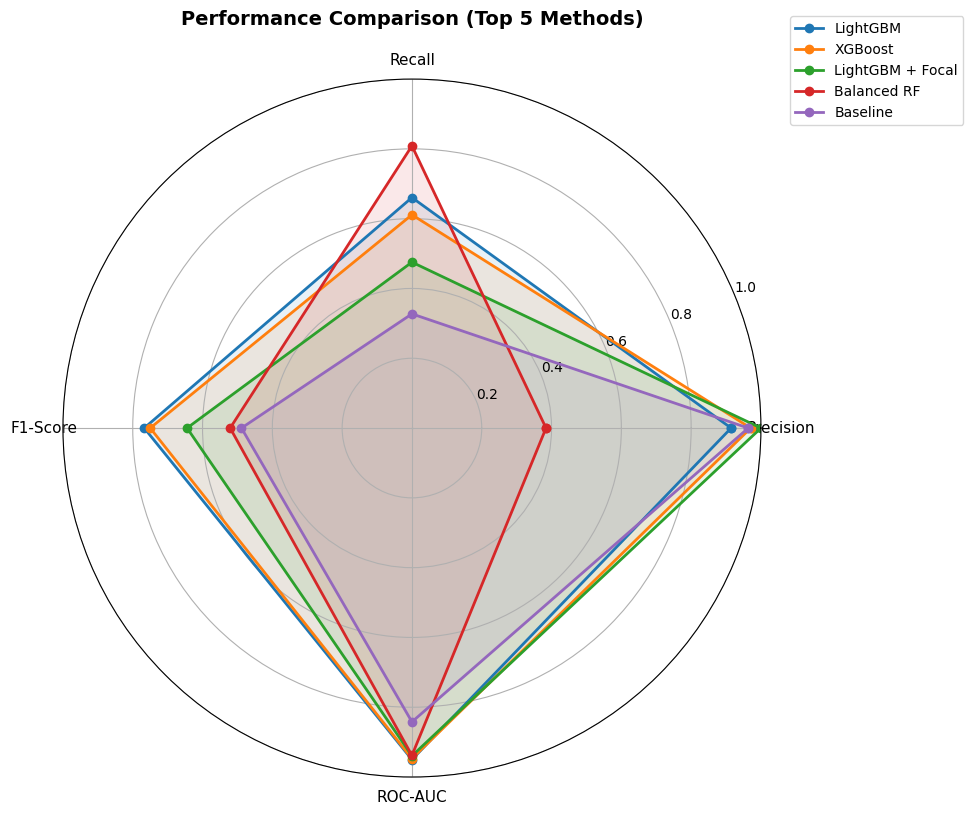

In [33]:
# レーダーチャートで可視化
from math import pi

# トップ5手法を選択
top_methods = all_results.nlargest(5, 'F1-Score')

categories = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

# 角度の計算
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for idx, row in top_methods.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Method'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Performance Comparison (Top 5 Methods)', 
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## 11. 実務でのベストプラクティス

### 手法選択のガイドライン

| シナリオ | 推奨手法 | 理由 |
|---------|---------|------|
| 軽度の不均衡（10:1以下） | クラス重み付け | シンプルで効果的 |
| 中程度の不均衡（10:1～100:1） | SMOTE + GBDTまたはBalanced RF | バランスが良い |
| 極端な不均衡（100:1以上） | SMOTEENN + Focal Loss | 過学習を抑制 |
| 見逃しのコストが高い | 閾値調整 + SMOTE | Recallを最大化 |
| 誤検知のコストが高い | クラス重み調整 | Precisionを優先 |
| 計算リソース豊富 | アンサンブル（EasyEnsemble等） | 最高性能 |
| 計算リソース限定 | クラス重み付け | 軽量 |

### チェックリスト

```python
# ✅ 不均衡データ対策チェックリスト

# 1. データの確認
# - クラス分布を可視化したか？
# - 不均衡率を確認したか？

# 2. 評価指標の選択
# - Accuracy以外の指標を使っているか？
# - ビジネス目標に合った指標か？
# - PR-AUCやF1-Scoreを見ているか？

# 3. 層化抽出
# - train_test_split で stratify を使ったか？
# - クロスバリデーションで StratifiedKFold を使ったか？

# 4. 対策手法の選択
# - 複数の手法を試したか？
# - リサンプリングはテストデータに適用していないか？
# - クラス重みやFocal Lossを検討したか？

# 5. 閾値の調整
# - デフォルト閾値(0.5)が最適か確認したか？
# - ビジネス要件に合わせて調整したか？

# 6. 検証
# - 混同行列を詳しく見たか？
# - False NegativeとFalse Positiveのバランスは適切か？
```

## 12. まとめ

### 本ノートブックで学んだこと

1. **不均衡データの問題**
   - クラス不均衡とは何か
   - なぜAccuracyが不適切か
   - 実世界での重要性

2. **適切な評価指標**
   - Precision、Recall、F1-Score
   - ROC-AUCとPR-AUC
   - ビジネス目標に応じた指標選択

3. **リサンプリング手法**
   - SMOTE、ADASYN、BorderlineSMOTE
   - アンダーサンプリング
   - ハイブリッド手法（SMOTEENN、SMOTETomek）

4. **アルゴリズムレベルの対策**
   - クラス重み付け
   - 閾値調整
   - コスト考慮学習

5. **高度な手法**
   - EasyEnsemble、Balanced Random Forest
   - GBDTの不均衡対策（scale_pos_weight）
   - Focal Loss

6. **実務での適用**
   - シナリオ別の手法選択
   - ベストプラクティス
   - チェックリスト

### 重要なポイント

- ✅ **Accuracyに騙されるな**: 不均衡データでは必ずPrecision、Recall、F1も確認
- ✅ **テストデータはリサンプリングしない**: 訓練データのみに適用
- ✅ **層化抽出を使う**: stratifyパラメータは必須
- ✅ **複数の手法を試す**: 1つの手法に固執しない
- ✅ **ビジネス要件を考慮**: 見逃しと誤検知のどちらが重要か
- ✅ **閾値を調整**: デフォルトの0.5が最適とは限らない

### 次のステップ

- Notebook 24で時系列特徴量エンジニアリングを学ぶ
- Notebook 25でカテゴリカル変数の高度な処理を学ぶ
- 実際のKaggleコンペで不均衡データに挑戦